# Spectral Purity Testing

I noticed that I'm not getting a very pure tone out of the SDR.

In [1]:
from charon_vna.vna import Charon, generate_tone
from matplotlib import pyplot as plt
from matplotlib.ticker import EngFormatter
import xarray as xr
import numpy as np
from bh_instruments import addresses
from bh_instruments.spectrum_analyzer import HP8563E
from retry import retry
from pyvisa import VisaIOError
from scipy.signal import argrelmin
from matplotlib.markers import CARETDOWN

In [2]:
# connect to devices
vna = Charon()
sa = HP8563E(addresses.ADDR_SA)  # a spectrum analyzer for characterizing the SDR

In [3]:
# set up device
vna.set_switches(1, 1)  # pick a port to do all of the testing on

In [4]:
# helpers
def stop_tx(vna: Charon):
    self = vna
    self.sdr.tx_destroy_buffer()

def tx_forever(vna: Charon, frequency: float, tx_gain: float):
    self = vna
    self.sdr.tx_destroy_buffer()
    self.sdr.tx_hardwaregain_chan0 = float(tx_gain)
    self.sdr.tx_lo = int(frequency - self.FREQUENCY_OFFSET)
    self.sdr.tx_cyclic_buffer = True
    # For some reason the pluto's DDS has truly horrendous phase noise to the point where it looks modulated
    self.sdr.tx(generate_tone(f=self.FREQUENCY_OFFSET, fs=self.sdr.sample_rate))
    # self.sdr.dds_single_tone(self.FREQUENCY_OFFSET, scale=0.9, channel=0)

@retry(VisaIOError)
def get_trace():
    """
    The spectrum analyzer sometimes gives me communication errors :(
    """
    return sa.get_trace().data

def db2v(db):
    return 10 ** (db / 20)

def v2db(v):
    return 20 * np.log10(v)

def db2w(db):
    return 10 ** (db / 10)

def w2db(w):
    return 10 * np.log10(w)


In [5]:
# measure things
fc = 120e6
bw = 20e6

frequency = np.linspace(-bw/2, +bw/2, sa.get_frequency()[2])
tx_gain = np.arange(-80, 0.0001, 0.5)

da = xr.DataArray(np.empty([len(frequency), len(tx_gain)], dtype=np.float64), dims=["frequency", "tx_gain"], coords=dict(
    frequency=frequency,
    tx_gain=tx_gain,
))

for g in tx_gain:
    print(g)
    tx_forever(vna, frequency=120e6, tx_gain=g)
    sa.set_bandwidth(30e3)
    sa.set_frequency(fc-bw/2, fc+bw/2)
    sa.set_trigger("single")
    da.loc[dict(tx_gain=g)] = get_trace()


-80.0
-79.5
-79.0
-78.5
-78.0
-77.5
-77.0
-76.5
-76.0
-75.5
-75.0
-74.5
-74.0
-73.5
-73.0
-72.5
-72.0
-71.5
-71.0
-70.5
-70.0
-69.5
-69.0
-68.5
-68.0
-67.5
-67.0
-66.5
-66.0
-65.5
-65.0
-64.5
-64.0
-63.5
-63.0
-62.5
-62.0
-61.5
-61.0
-60.5
-60.0
-59.5
-59.0
-58.5
-58.0
-57.5
-57.0
-56.5
-56.0
-55.5
-55.0
-54.5
-54.0
-53.5
-53.0
-52.5
-52.0
-51.5
-51.0
-50.5
-50.0
-49.5
-49.0
-48.5
-48.0
-47.5
-47.0
-46.5
-46.0
-45.5
-45.0
-44.5
-44.0
-43.5
-43.0
-42.5
-42.0
-41.5
-41.0
-40.5


ValueError: timeout value is invalid

In [ ]:
stop_tx(vna)
sa.set_trigger("single")
noise_floor = get_trace()

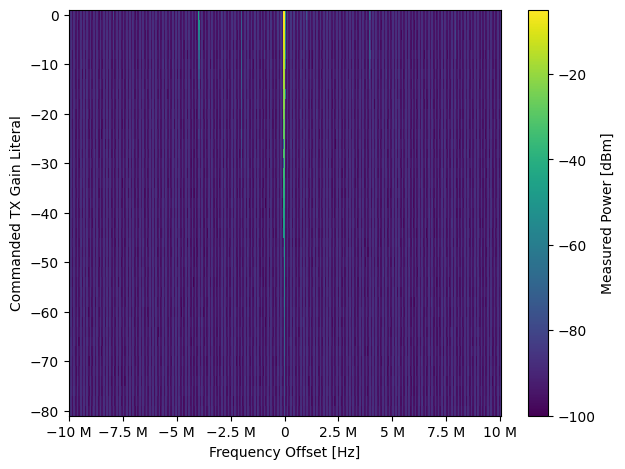

In [ ]:
plt.pcolormesh(da.frequency, da.tx_gain, da.T, cmap="viridis")
plt.colorbar(label="Measured Power [dBm]")
plt.xlabel("Frequency Offset [Hz]")
plt.ylabel("Commanded TX Gain Literal")
plt.gca().xaxis.set_major_formatter(EngFormatter())
plt.tight_layout()

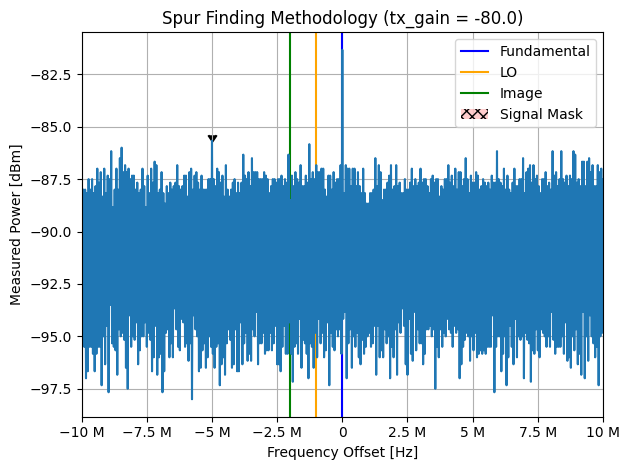

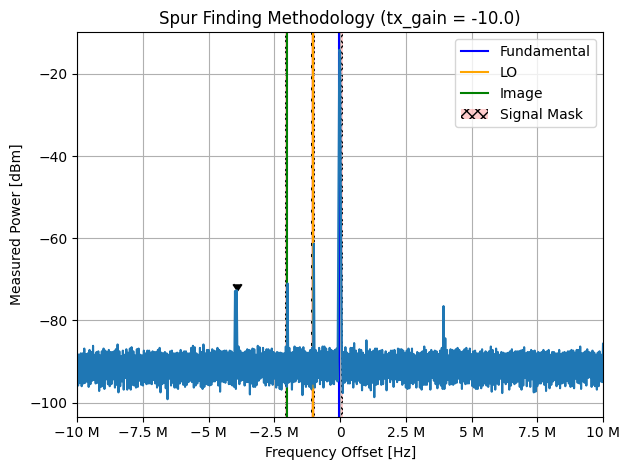

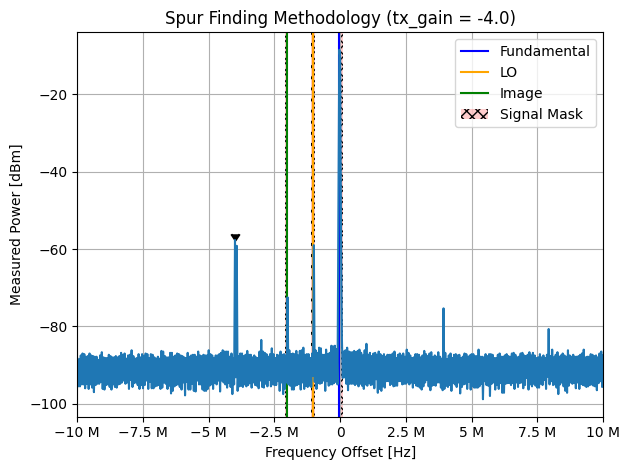

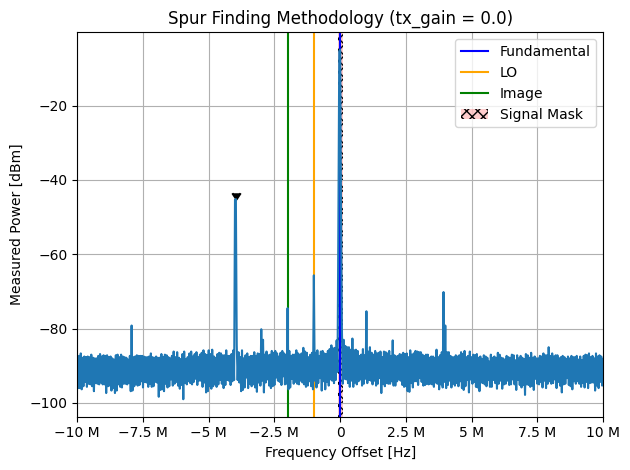

In [ ]:
noise_power = w2db(np.mean(db2w(noise_floor)))
peak_power = da.max(dim="frequency")
lo_power = xr.zeros_like(peak_power)
image_power = xr.zeros_like(peak_power)
spur_power = xr.zeros_like(peak_power)
for gg, g in enumerate(tx_gain):
    da_g = da.sel(tx_gain=g)

    # find the peak
    # This is around the 0 Hz offset but depending on discrepancies of reference oscillators may be slightly off
    idx_peak = np.argmax(da_g.data, axis=da_g.dims.index("frequency"))
    freq_peak = da_g.frequency[idx_peak].data

    freq_lo = freq_peak - vna.FREQUENCY_OFFSET
    idx_lo = np.abs(da_g.frequency.data - freq_lo).argmin()

    freq_image = freq_peak - 2 * vna.FREQUENCY_OFFSET
    idx_image = np.abs(da_g.frequency.data - freq_image).argmin()

    # find all local minima
    idx_min = argrelmin(da_g.data, axis=da_g.dims.index("frequency"))[0]

    # find the local minima on either side of each signal
    # peak
    idx_lower = np.max(idx_min[idx_min < idx_peak])
    idx_upper = np.min(idx_min[idx_min > idx_peak])
    # lo
    idx_lo_lower = np.max(idx_min[idx_min < idx_lo])
    idx_lo_upper = np.min(idx_min[idx_min > idx_lo])
    # image
    idx_image_lower = np.max(idx_min[idx_min < idx_image])
    idx_image_upper = np.min(idx_min[idx_min > idx_image])

    # mask off the main signal
    idx_mask = np.arange(len(da_g.frequency), dtype=int)
    da_g_masked = da_g[
        ((idx_mask < idx_lower) | (idx_mask > idx_upper)) &
        ((idx_mask < idx_lo_lower) | (idx_mask > idx_lo_upper)) &
        ((idx_mask < idx_image_lower) | (idx_mask > idx_image_upper))
    ]

    # find the peak of what remains
    freq_spur = da_g_masked.idxmax()
    spur_power.loc[dict(tx_gain=g)] = da_g_masked.max()

    # extract the other peaks
    lo_power.loc[dict(tx_gain=g)] = da_g[(idx_mask >= idx_lo_lower) & (idx_mask <= idx_lo_upper)].max()
    image_power.loc[dict(tx_gain=g)] = da_g[(idx_mask >= idx_image_lower) & (idx_mask <= idx_image_upper)].max()

    # the highest power measurement will most clearly illustrate spurious content
    if gg in [0, 70/2, 76/2, len(tx_gain) - 1]:
        plt.figure()
        plt.axvline(freq_peak, color="blue", label="Fundamental")
        plt.axvline(freq_lo, color="orange", label="LO")
        plt.axvline(freq_image, color="green", label="Image")
        plt.plot(da_g.frequency, da_g)
        plt.scatter(freq_spur, da_g.sel(frequency=freq_spur), marker=CARETDOWN, color="k")
        # plt.gca().annotate("spur", (freq_spur, da_g.sel(frequency=freq_spur)), va="bottom", ha="center")
        plt.axvspan(da_g.frequency[idx_lower], da_g.frequency[idx_upper], facecolor="r", alpha=0.2, hatch="xxx", label="Signal Mask")
        plt.axvspan(da_g.frequency[idx_lo_lower], da_g.frequency[idx_lo_upper], facecolor="r", alpha=0.2, hatch="xxx")
        plt.axvspan(da_g.frequency[idx_image_lower], da_g.frequency[idx_image_upper], facecolor="r", alpha=0.2, hatch="xxx")
        plt.xlim(da_g.frequency[0], da_g.frequency[-1])
        plt.xlabel("Frequency Offset [Hz]")
        plt.ylabel("Measured Power [dBm]")
        plt.title(f"Spur Finding Methodology (tx_gain = {g})")
        plt.legend()
        plt.gca().xaxis.set_major_formatter(EngFormatter())
        plt.grid(True)
        plt.tight_layout()


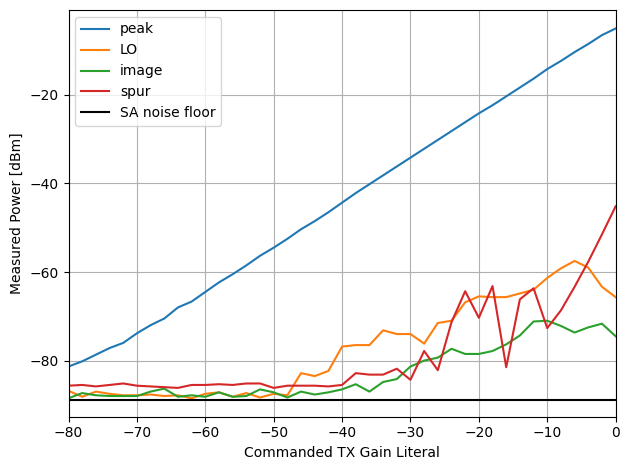

In [ ]:
plt.plot(da.tx_gain, peak_power, label="peak")
plt.plot(da.tx_gain, lo_power, label="LO")
plt.plot(da.tx_gain, image_power, label="image")
plt.plot(da.tx_gain, spur_power, label="spur")
plt.axhline(noise_power, color="black", label="SA noise floor")
plt.xlabel("Commanded TX Gain Literal")
plt.ylabel("Measured Power [dBm]")
plt.xlim(da.tx_gain[0], da.tx_gain[-1])
plt.grid(True)
plt.legend()
plt.tight_layout()

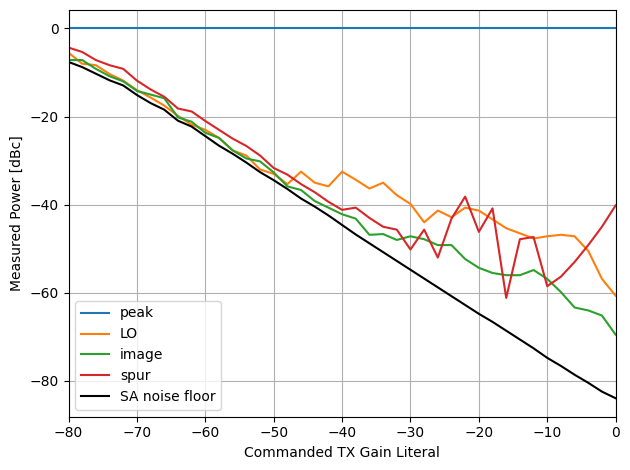

In [ ]:
plt.plot(da.tx_gain, peak_power - peak_power, label="peak")
plt.plot(da.tx_gain, lo_power - peak_power, label="LO")
plt.plot(da.tx_gain, image_power - peak_power, label="image")
plt.plot(da.tx_gain, spur_power - peak_power, label="spur")
plt.plot(da.tx_gain, noise_power - peak_power, color="black", label="SA noise floor")
plt.xlabel("Commanded TX Gain Literal")
plt.ylabel("Measured Power [dBc]")
plt.xlim(da.tx_gain[0], da.tx_gain[-1])
plt.grid(True)
plt.legend()
plt.tight_layout()